In [1]:
%pip install yfinance ta matplotlib pandas numpy

Note: you may need to restart the kernel to use updated packages.


In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

def download_data(ticker="GOOGL", start="2015-01-01", end=None, min_data_points=250):
    """
    Download and validate stock data with enhanced error handling.
    
    Parameters:
    - ticker: Stock ticker symbol (e.g., 'GOOGL', 'AAPL')
    - start: Start date (YYYY-MM-DD format)
    - end: End date (None = today)
    - min_data_points: Minimum required data points for analysis
    
    Returns:
    - DataFrame with validated OHLCV data
    """
    if end is None:
        end = pd.Timestamp.today().strftime("%Y-%m-%d")
    
    print(f"Downloading {ticker} from {start} to {end} ...")
    
    try:
        df = yf.download(ticker, start=start, end=end, progress=False)
        
        # Validate data exists
        if df.empty:
            raise ValueError(f"No data found for ticker {ticker}")
        
        if len(df) < min_data_points:
            raise ValueError(f"Insufficient data: {len(df)} points < minimum {min_data_points}")
        
        df.index = pd.to_datetime(df.index)
        
        # Check for required columns
        required_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
        if not all(col in df.columns for col in required_cols):
            raise ValueError(f"Missing required columns. Found: {df.columns.tolist()}")
        
        print(f"✓ Successfully downloaded {len(df)} trading days of data")
        print(f"  Date range: {df.index[0].date()} to {df.index[-1].date()}")
        
        return df
        
    except Exception as e:
        print(f"✗ Error downloading data: {str(e)}")
        raise

df = download_data("GOOGL", "2015-01-01")
print(df)

✓ Successfully downloaded 2781 trading days of data
  Date range: 2015-01-02 to 2026-01-23
Price            Close        High         Low        Open    Volume
Ticker           GOOGL       GOOGL       GOOGL       GOOGL     GOOGL
Date                                                                
2015-01-02   26.278944   26.589101   26.196068   26.430299  26480000
2015-01-05   25.778229   26.201531   25.693371   26.159846  41182000
2015-01-06   25.142033   25.865068   25.087941   25.829835  54456000
2015-01-07   25.068094   25.382717   24.993658   25.355920  46918000
2015-01-08   25.155434   25.184711   24.565390   24.887458  73054000
...                ...         ...         ...         ...       ...
2026-01-16  330.000000  334.649994  327.700012  334.410004  40341600
2026-01-20  322.000000  327.730011  320.429993  320.869995  35361000
2026-01-21  328.380005  332.480011  319.350006  320.920013  35386600
2026-01-22  330.540009  335.149994  328.750000  334.450012  26253600
2026-01-23  

In [3]:
TICKER = 'GOOGL' 
if isinstance(df.columns, pd.MultiIndex):
    if TICKER in df.columns.get_level_values(1):
        df = df.xs(TICKER, axis=1, level=1)
    elif TICKER in df.columns.get_level_values(0):
        df = df.xs(TICKER, axis=1, level=0)
    else:
       
        df.columns = df.columns.get_level_values(-1)
else:
    
    pass

print(f"Using columns: {df.columns.tolist()}")
# Data quality checks
def validate_data_quality(df, tolerance=0.05):
    """
    Perform comprehensive data quality validation.
    
    Parameters:
    - df: Input DataFrame
    - tolerance: Maximum allowed percentage of missing values (5% default)
    
    Returns:
    - Cleaned DataFrame with validation report
    """
    print("\n=== Data Quality Report ===")

    # Check for missing values
    missing_pct = df.isnull().sum() / len(df) * 100
    if (missing_pct > tolerance).any():
        print(f"⚠ Missing values detected:\n{missing_pct[missing_pct > 0]}")
    else:
        print(f"✓ No significant missing values (threshold: {tolerance}%)")
    
    # Fill missing values using forward fill then backward fill
    df = df.ffill().bfill()
    
    # Check for invalid prices (negative, zero, or extreme values)
    # Safely handle multi-column or MultiIndex cases
    invalid_mask = df[['Close', 'Open']].le(0).any(axis=1)
    if invalid_mask.any():
        print(f"⚠ Invalid prices detected in {invalid_mask.sum()} rows")
        df = df[~invalid_mask]
    
    # Detect outliers using IQR method on daily returns
    daily_return_raw = df['Close'].pct_change()

    # Ensure it's a Series (if df['Close'] is accidentally a DataFrame)
    if isinstance(daily_return_raw, pd.DataFrame):
        daily_return_raw = daily_return_raw.iloc[:, 0]

    Q1 = daily_return_raw.quantile(0.25)
    Q3 = daily_return_raw.quantile(0.75)
    IQR = Q3 - Q1
    outlier_threshold = 3 * IQR  # 3x IQR threshold

    outliers = ((daily_return_raw < Q1 - outlier_threshold) | 
                (daily_return_raw > Q3 + outlier_threshold))

    # Replace NaN (first row) with False to safely evaluate
    outliers = outliers.fillna(False)

    if outliers.any():
        print(f"ℹ Detected {outliers.sum()} potential outlier days (return > 3×IQR)")
        # Align outliers Series with df index to avoid index mismatch
        df = df.copy()  # Make a copy to safely assign new column
        df['Is_Outlier'] = outliers.reindex(df.index, fill_value=False)
    
    # Check data consistency
    high_low_valid = df['High'] >= df['Low']
    close_range_valid = (df['Close'] >= df['Low']) & (df['Close'] <= df['High'])

    # Safely check if there are any invalid rows
    if not high_low_valid.all() or not close_range_valid.all():
        print(f"⚠ Data consistency issues found, correcting...")
        df = df[high_low_valid & close_range_valid]
    
    # Clean up temporary columns
    df = df.drop(columns=['Is_Outlier'], errors='ignore')
    
    print(f"✓ Data validation complete. Final records: {len(df)}")

    return df

# === Run data quality validation ===
df = validate_data_quality(df)


Using columns: ['Close', 'High', 'Low', 'Open', 'Volume']

=== Data Quality Report ===
✓ No significant missing values (threshold: 0.05%)
ℹ Detected 28 potential outlier days (return > 3×IQR)
✓ Data validation complete. Final records: 2781


In [4]:
import ta  # technical analysis library
from ta.momentum import RSIIndicator
from ta.trend import MACD

def compute_indicators(df, ma_short=10, ma_long=30, rsi_window=14, 
                       macd_fast=12, macd_slow=26, macd_signal=9):
    """
    Compute technical indicators with adaptive parameters and missing value handling.
    
    Parameters:
    - df: OHLCV DataFrame
    - ma_short, ma_long: Moving average windows (adaptive to data type)
    - rsi_window, macd_fast, macd_slow, macd_signal: Indicator parameters
    
    Returns:
    - DataFrame with computed indicators
    """
    df = df.copy()
    
    # === Moving Averages with missing value handling ===
    try:
        df['MA10'] = df['Close'].rolling(window=ma_short, min_periods=1).mean()
        df['MA30'] = df['Close'].rolling(window=ma_long, min_periods=1).mean()
        print(f"✓ Moving averages computed: MA{ma_short}, MA{ma_long}")
    except Exception as e:
        print(f"✗ Error computing MAs: {e}")
        df['MA10'] = np.nan
        df['MA30'] = np.nan
    
    # === RSI with validation ===
    try:
        if len(df) >= rsi_window:
            rsi_indicator = RSIIndicator(df['Close'].squeeze(), window=rsi_window)
            df['RSI'] = rsi_indicator.rsi()
            # Handle NaN values at the start (updated API)
            df['RSI'] = df['RSI'].bfill()
            print(f"✓ RSI computed: window={rsi_window}")
        else:
            print(f"⚠ Insufficient data for RSI (need {rsi_window}, have {len(df)})")
            df['RSI'] = np.nan
    except Exception as e:
        print(f"✗ Error computing RSI: {e}")
        df['RSI'] = np.nan
    
    # === MACD with validation ===
    try:
        if len(df) >= macd_slow:
            macd_obj = MACD(df['Close'].squeeze(), 
                           window_slow=macd_slow, 
                           window_fast=macd_fast, 
                           window_sign=macd_signal)
            df["MACD"] = macd_obj.macd()
            df["MACD_Signal"] = macd_obj.macd_signal()
            df["MACD_Hist"] = macd_obj.macd_diff()
            
            # Fill initial NaN values (updated API)
            df[["MACD", "MACD_Signal", "MACD_Hist"]] = \
                df[["MACD", "MACD_Signal", "MACD_Hist"]].bfill()
            
            print(f"✓ MACD computed: fast={macd_fast}, slow={macd_slow}, signal={macd_signal}")
        else:
            print(f"⚠ Insufficient data for MACD (need {macd_slow}, have {len(df)})")
            df["MACD"] = np.nan
            df["MACD_Signal"] = np.nan
            df["MACD_Hist"] = np.nan
    except Exception as e:
        print(f"✗ Error computing MACD: {e}")
        df["MACD"] = np.nan
        df["MACD_Signal"] = np.nan
        df["MACD_Hist"] = np.nan
    
    # === Data integrity check ===
    null_counts = df[['MA10', 'MA30', 'RSI', 'MACD']].isnull().sum()
    if (null_counts > len(df) * 0.3).any():  # More than 30% null
        print("⚠ Warning: Significant NaN values in indicators")
    
    print(f"\n✓ Indicator computation complete")
    return df

df = compute_indicators(df)
print("\nIndicator preview:")
print(df[['Close', 'MA10', 'MA30', 'RSI', 'MACD', 'MACD_Signal']])

✓ Moving averages computed: MA10, MA30
✓ RSI computed: window=14
✓ MACD computed: fast=12, slow=26, signal=9

✓ Indicator computation complete

Indicator preview:
Price            Close        MA10        MA30        RSI      MACD  \
Date                                                                  
2015-01-02   26.278944   26.278944   26.278944  68.174137  0.141992   
2015-01-05   25.778229   26.028586   26.028586  68.174137  0.141992   
2015-01-06   25.142033   25.733068   25.733068  68.174137  0.141992   
2015-01-07   25.068094   25.566825   25.566825  68.174137  0.141992   
2015-01-08   25.155434   25.484547   25.484547  68.174137  0.141992   
...                ...         ...         ...        ...       ...   
2026-01-16  330.000000  327.332001  317.098078  64.042841  7.429937   
2026-01-20  322.000000  327.878000  317.250999  53.503296  6.518558   
2026-01-21  328.380005  329.282001  317.495000  59.261325  6.239175   
2026-01-22  330.540009  330.138000  318.055667  61.02126

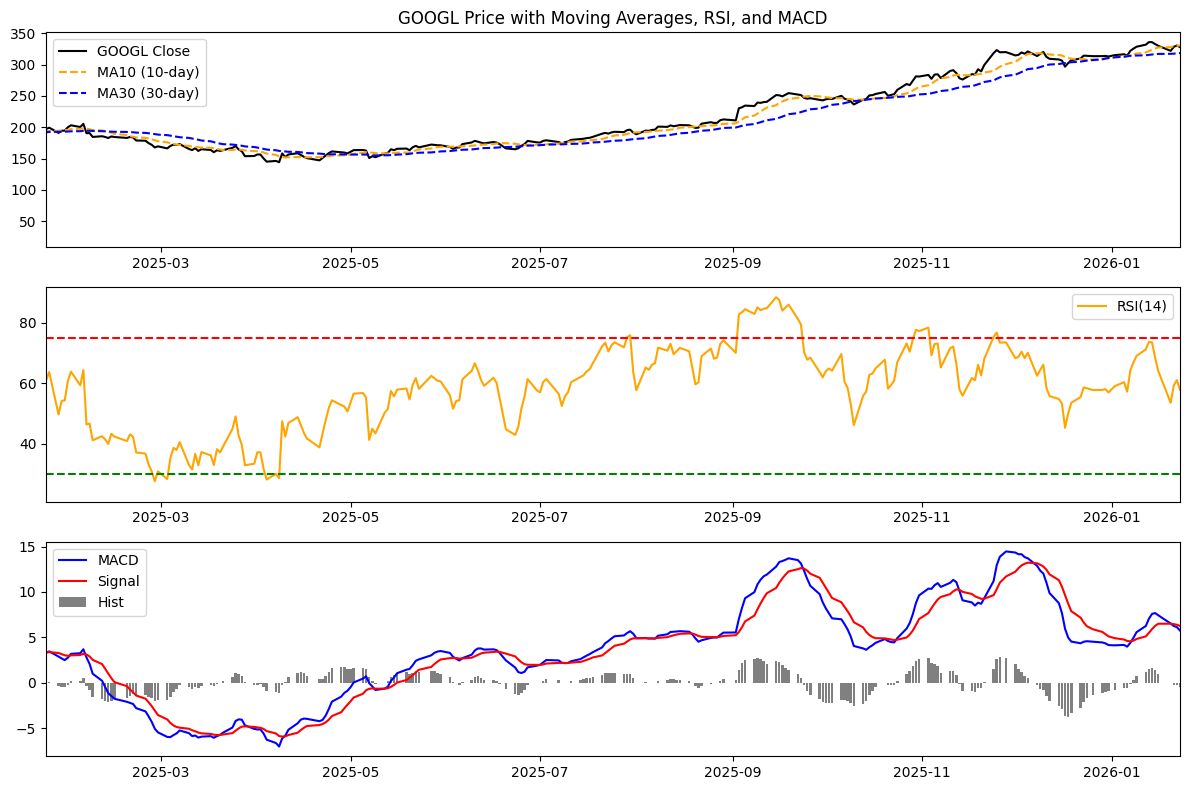

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))

# close price
plt.subplot(3,1,1)
plt.plot(df['Close'], label='GOOGL Close', color='black')
plt.plot(df['MA10'], label='MA10 (10-day)', color='orange', linestyle='--')
plt.plot(df['MA30'], label='MA30 (30-day)', color='blue', linestyle='--')
plt.title('GOOGL Price with Moving Averages, RSI, and MACD')
plt.xlim(df.index[-252], df.index[-1])
plt.legend()

# RSI
plt.subplot(3,1,2)
plt.plot(df['RSI'], label='RSI(14)', color='orange')
plt.axhline(75, color='red', linestyle='--')
plt.axhline(30, color='green', linestyle='--')
plt.xlim(df.index[-252], df.index[-1])
plt.legend()

# MACD 
plt.subplot(3,1,3)
plt.plot(df['MACD'], label='MACD', color='blue')
plt.plot(df['MACD_Signal'], label='Signal', color='red')
plt.bar(df.index, df['MACD_Hist'], label='Hist', color='gray')
plt.legend()
plt.xlim(df.index[-252], df.index[-1])
plt.tight_layout()
plt.show()

✓ Signal generation complete:
  Buy signals : 1048
  Sell signals: 64
  Avg position: 57.47%
  Max position: 70.00%
  Min position: 0.00%
Price             RSI        MA10        MA30      MACD  MACD_Signal  Position
Date                                                                          
2025-12-24  58.326961  308.107001  306.432806  4.570831     6.225385  0.664167
2025-12-26  57.723701  308.215002  307.332387  4.519118     5.884132  0.665523
2025-12-29  57.764247  308.642001  308.504790  4.431090     5.593524  0.665734
2025-12-30  58.015821  309.205002  309.758813  4.334760     5.341771  0.664310
2025-12-31  56.945191  309.848001  310.697691  4.142083     5.101833  0.670163
2026-01-02  59.005889  311.691000  311.732885  4.115430     4.904553  0.659854
2026-01-05  60.327929  313.099002  312.530265  4.158534     4.755349  0.648385
2026-01-06  57.184582  313.817001  313.366238  3.969414     4.598162  0.663448
2026-01-07  64.167067  315.037003  314.116768  4.385468     4.555623  0.

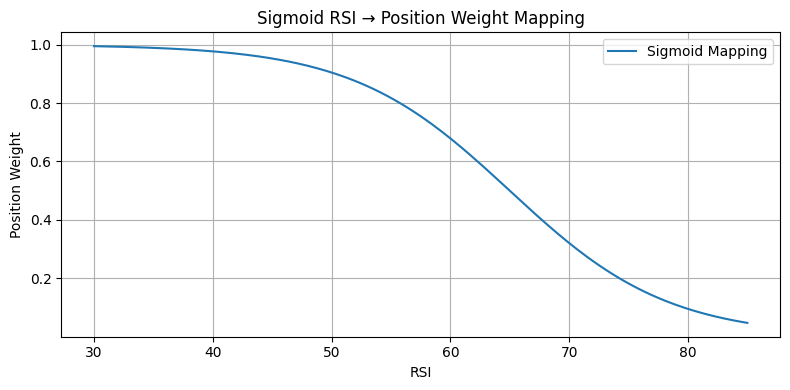

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


def sigmoid_weight(rsi, mid=75, steepness=0.04):
    """
    Maps RSI values to position weights using a sigmoid function.
    RSI ↑ → weight ↓
    """
    if pd.isna(rsi):
        return 0.5
    try:
        return 1 / (1 + np.exp(steepness * (rsi - mid)))
    except (OverflowError, RuntimeWarning):
        return 0.5


def generate_dynamic_signals(
    df,
    position_cap=0.7,
    ma10='MA10',
    ma30='MA30',
    rsi_mid=75,
    sigmoid_steepness=0.04,
    smoothing_span=2,
    warmup_periods=30,
    sell_reduction=0.1
):
    """
    Trend-following strategy with TRUE RSI-sigmoid-based position sizing.
    """
    df = df.copy()

    # === Validation ===
    required_cols = [ma10, ma30, 'RSI', 'MACD', 'MACD_Signal']
    for col in required_cols:
        if col not in df.columns:
            raise ValueError(f"Missing required column: {col}")

    # === Fill missing values ===
    df[ma10] = df[ma10].ffill()
    df[ma30] = df[ma30].ffill()
    df['RSI'] = df['RSI'].ffill()
    df['MACD'] = df['MACD'].ffill()
    df['MACD_Signal'] = df['MACD_Signal'].ffill()

    # === Signal conditions ===
    buy_condition = (df[ma10] > df[ma30]) & (df['MACD'] > df['MACD_Signal'])
    rsi_trend_cross = (df["RSI"] > 55) & (df["RSI"].shift(1) <= 55)
    sell_condition = (df[ma10] < df[ma30]) & rsi_trend_cross
    
    buy_signal = buy_condition.shift(1).fillna(False)
    sell_signal = sell_condition.shift(1).fillna(False)

    # === Position state (trend direction only) ===
    position_state = pd.Series(np.nan, index=df.index)
    position_state[buy_signal] = 1.0
    position_state[sell_signal] = sell_reduction
    position_state = position_state.ffill().fillna(0.0)

    # === TRUE RSI sigmoid position sizing ===
    rsi_weights = df['RSI'].apply(
        lambda x: sigmoid_weight(x, mid=rsi_mid, steepness=sigmoid_steepness)
    )

    df['Position'] = position_state * rsi_weights

    # === EMA smoothing ===
    df['Position'] = df['Position'].ewm(
        span=smoothing_span, adjust=False
    ).mean()

    # === Only cap upper bound ===
    df['Position'] = df['Position'].clip(upper=position_cap)

    # === Warmup period ===
    df.loc[:df.index[warmup_periods], 'Position'] = 0.0

    # === Reporting ===
    valid_positions = df[df.index >= df.index[warmup_periods]]['Position']
    print("✓ Signal generation complete:")
    print(f"  Buy signals : {buy_signal.sum()}")
    print(f"  Sell signals: {sell_signal.sum()}")
    print(f"  Avg position: {valid_positions.mean():.2%}")
    print(f"  Max position: {valid_positions.max():.2%}")
    print(f"  Min position: {valid_positions.min():.2%}")

    return df


# ===== Example usage =====
df = generate_dynamic_signals(df)

print(
    df[["RSI", "MA10", "MA30", "MACD", "MACD_Signal", "Position"]].tail(20)
)

# ===== Visualize sigmoid mapping =====
rsi_vals = np.linspace(30, 85, 200)
weights = 1 / (1 + np.exp(0.15 * (rsi_vals - 65)))

plt.figure(figsize=(8, 4))
plt.plot(rsi_vals, weights, label="Sigmoid Mapping")
plt.xlabel("RSI")
plt.ylabel("Position Weight")
plt.title("Sigmoid RSI → Position Weight Mapping")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [7]:
import numpy as np
import pandas as pd

def backtest(df, cost=0.001, initial_capital=1_000_000, trade_threshold=0.1):
    df = df.copy()
    
    # === Validate required columns ===
    required_cols = ['Close', 'Position']
    missing_cols = [col for col in required_cols if col not in df.columns]
    if missing_cols:
        raise ValueError(f"Missing required columns for backtest: {missing_cols}")

    # === Daily returns ===
    df["Return"] = df["Close"].pct_change().fillna(0)

    # === Position changes & transaction costs ===
    df["Trade_Change"] = df["Position"].diff().abs().fillna(0)

    # Ignore small position changes to reduce noise and turnover
    df["Effective_Trade"] = np.where(df["Trade_Change"] > trade_threshold,
                                     df["Trade_Change"], 0)
    df["Cost"] = df["Effective_Trade"] * cost

    # === Strategy returns ===
    df["Strategy_Return"] = (df["Position"].shift(1) * df["Return"] - df["Cost"]).fillna(0)

    # === Equity curve ===
    # Cumulative portfolio value starting from initial capital
    df["Equity"] = (1 + df["Strategy_Return"]).cumprod() * initial_capital

    # === Performance metrics ===
    days = max((df.index[-1] - df.index[0]).days, 1)
    years = days / 365
    start_value = df["Equity"].iloc[0]
    end_value = df["Equity"].iloc[-1]

    # Compound Annual Growth Rate
    CAGR = (end_value / start_value) ** (1 / years) - 1

    # Risk-adjusted return (annualized Sharpe ratio)
    daily_mean = df["Strategy_Return"].mean()
    daily_std = df["Strategy_Return"].std()
    Sharpe = np.sqrt(252) * (daily_mean / daily_std) if daily_std != 0 else 0
   
    # Maximum drawdown measures peak-to-trough loss
    df["Drawdown"] = df["Equity"] / df["Equity"].cummax() - 1
    Max_Drawdown = df["Drawdown"].min()

    # Daily win rate: proportion of profitable trading days
    WinRate_Daily = (df["Strategy_Return"] > 0).sum() / \
                    (df["Strategy_Return"] != 0).sum() if (df["Strategy_Return"] != 0).sum() > 0 else np.nan

    metrics = {
        "CAGR": CAGR,
        "Sharpe": Sharpe,
        "Max_Drawdown": Max_Drawdown,
        "WinRate_Daily": WinRate_Daily
    }

    print(f"CAGR: {CAGR:.2%}, Sharpe: {Sharpe:.2f}, "
          f"Max DD: {Max_Drawdown:.2%}, WinRate(D): {WinRate_Daily:.2%}")
    
    # Note: Keep Effective_Trade and Drawdown for visualization purposes
    # Only remove truly redundant temporary columns
    temp_cols = ['Trade_Change', 'Cost', 'Return']
    df_clean = df.drop(columns=temp_cols, errors='ignore')

    return metrics, df_clean

In [8]:
# === Run backtest with current position method ===
metrics, bt_df = backtest(df, cost=0.001, initial_capital=1_000_000, trade_threshold=0.1)

CAGR: 15.60%, Sharpe: 0.91, Max DD: -31.06%, WinRate(D): 53.66%


In [9]:
import json

# Save metrics with enhanced metadata
metrics_enhanced = {
    "strategy_config": {
        "ticker": "GOOGL",
        "ma_short": 10,
        "ma_long": 30,
        "rsi_window": 14,
        "position_cap": 0.7,
        "transaction_cost": 0.001,
        "trade_threshold": 0.1
    },
    "backtest_results": metrics,
    "data_quality": {
        "total_records": len(bt_df),
        "critical_cols_nulls": bt_df[['Close', 'MA10', 'MA30', 'RSI', 'MACD', 'Position']].isnull().sum().to_dict(),
        "data_integrity_check": {
            "has_nans": bool(bt_df[['Close', 'MA10', 'MA30', 'RSI', 'MACD', 'Position']].isnull().any().any()),
            "price_range": f"${bt_df['Close'].min():.2f} - ${bt_df['Close'].max():.2f}",
            "position_range": f"{bt_df['Position'].min():.2%} - {bt_df['Position'].max():.2%}"
        }
    }
}

with open("metrics.json", "w") as f:
    json.dump(metrics_enhanced, f, indent=2, default=str)

print("✓ Metrics saved to metrics.json")
print("\nMetrics preview:")
for key, value in metrics.items():
    if isinstance(value, float):
        print(f"  {key}: {value:.4f}")
    else:
        print(f"  {key}: {value}")

✓ Metrics saved to metrics.json

Metrics preview:
  CAGR: 0.1560
  Sharpe: 0.9059
  Max_Drawdown: -0.3106
  WinRate_Daily: 0.5366


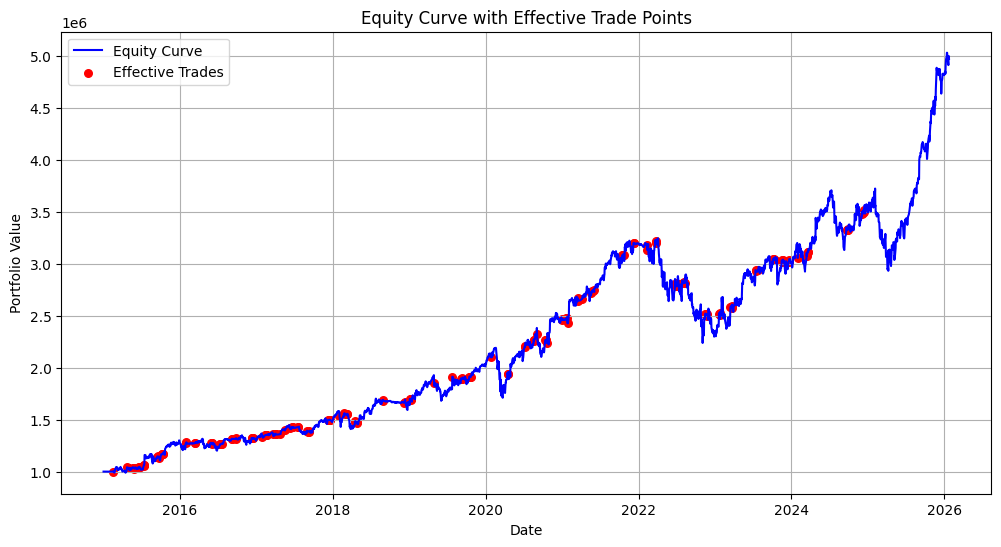

In [10]:
plt.figure(figsize=(12,6))
plt.plot(bt_df["Equity"], label="Equity Curve", color="blue")

# Highlight effective trade points
trade_dates = bt_df.index[bt_df["Effective_Trade"] > 0]
plt.scatter(trade_dates,
            bt_df.loc[trade_dates, "Equity"],
            color="red", label="Effective Trades", s=30)

plt.title("Equity Curve with Effective Trade Points")
plt.xlabel("Date")
plt.ylabel("Portfolio Value")
plt.legend()
plt.grid(True)
plt.show()

In [11]:
import matplotlib.pyplot as plt

def plot_equity_and_position(bt_df):
    plt.figure(figsize=(12,6))

     # --- Left axis: equity curve ---
    ax1 = plt.gca()
    ax1.plot(bt_df["Equity"], label="Equity Curve", color="blue", linewidth=2)
    ax1.set_ylabel("Portfolio Value", color="blue")
    ax1.tick_params(axis="y", labelcolor="blue")

    # --- Right axis: position exposure ----
    ax2 = ax1.twinx()
    ax2.plot(bt_df["Position"], label="Position (0–1)", color="orange", alpha=0.6, linewidth=1.8)
    ax2.set_ylabel("Position", color="orange")
    ax2.tick_params(axis="y", labelcolor="orange")

    # --- Red dots: effective trade days ---
    trade_dates = bt_df.index[bt_df["Effective_Trade"] > 0]
    ax1.scatter(trade_dates,
                bt_df.loc[trade_dates, "Equity"],
                color="red", s=25, label="Effective Trade")

    # --- Title & legends ---
    plt.title("Dynamic Position Backtest: GOOGL (2015–2025)", fontsize=13)
    ax1.legend(loc="upper left")
    ax2.legend(loc="upper right")
    ax2.plot(bt_df["Position"].rolling(5).mean(), color="orange", alpha=0.7)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


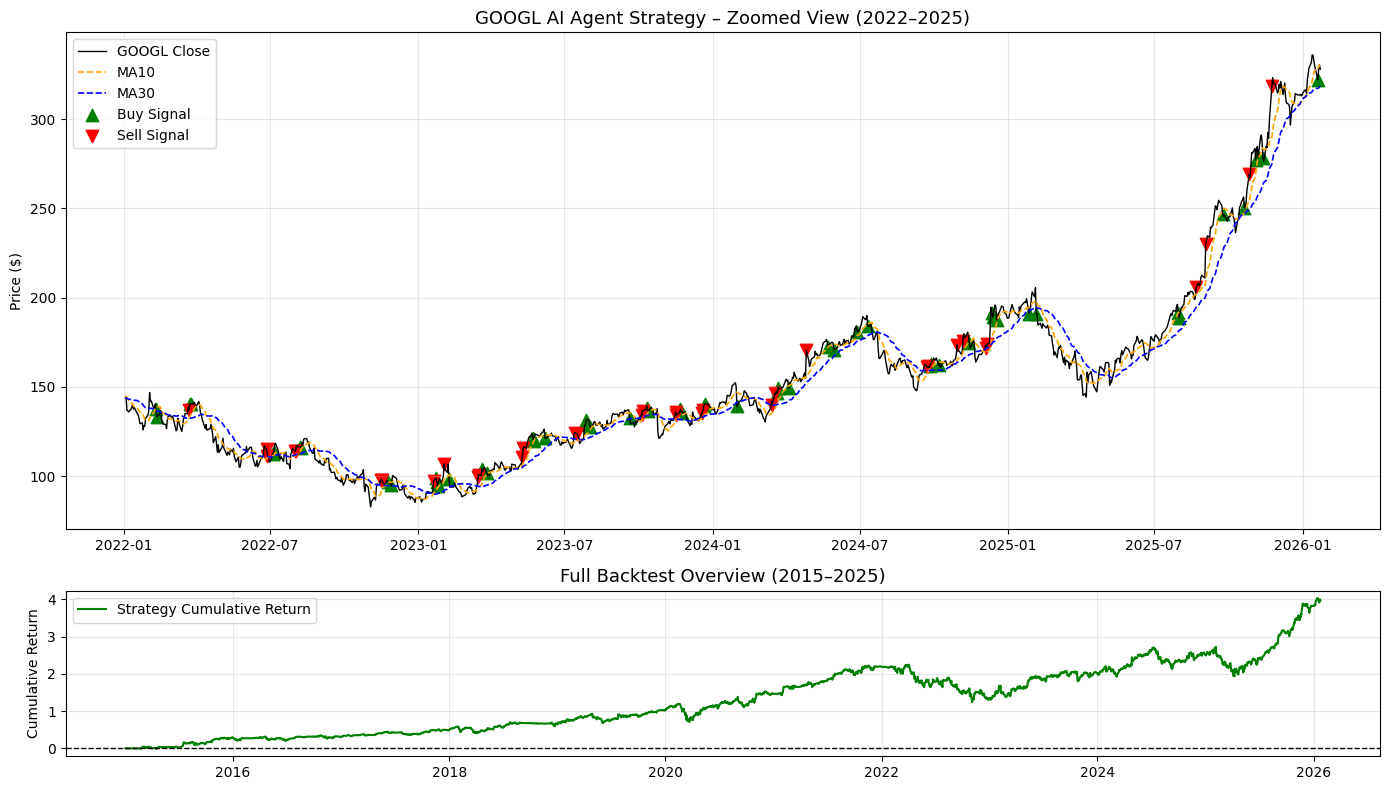

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# === Define time window (recent three years) ===
recent_bt = bt_df.loc["2022":]

# === Create stacked subplots ===
fig, (ax1, ax2) = plt.subplots(
    2, 1,
    figsize=(14, 8),
    gridspec_kw={'height_ratios': [3, 1]}
)

# =========================
# Plot 1: Rebalancing details (price + signals) from 2022
# =========================
ax1.plot(recent_bt.index, recent_bt["Close"],
         label="GOOGL Close", color="black", linewidth=1)

ax1.plot(recent_bt.index, recent_bt["MA10"],
         label="MA10", color="orange", linestyle="--", linewidth=1.2)

ax1.plot(recent_bt.index, recent_bt["MA30"],
         label="MA30", color="blue", linestyle="--", linewidth=1.2)

# --- Significant position change threshold ---
threshold = 0.05
buy_points = recent_bt[recent_bt["Position"].diff() > threshold]
sell_points = recent_bt[recent_bt["Position"].diff() < -threshold]

ax1.scatter(buy_points.index, buy_points["Close"],
            marker="^", color="green", s=80, label="Buy Signal")

ax1.scatter(sell_points.index, sell_points["Close"],
            marker="v", color="red", s=80, label="Sell Signal")

ax1.set_title("GOOGL AI Agent Strategy – Zoomed View (2022–2025)", fontsize=13)
ax1.set_ylabel("Price ($)")
ax1.legend(loc="upper left")
ax1.grid(alpha=0.3)

# =========================
# Plot 2: Full backtest overview from 2015
# =========================
equity_norm = bt_df["Equity"] / bt_df["Equity"].iloc[0] - 1

ax2.plot(bt_df.index, equity_norm,
         label="Strategy Cumulative Return", color="green", linewidth=1.5)

ax2.axhline(0, color="black", linestyle="--", linewidth=1)
ax2.set_title("Full Backtest Overview (2015–2025)", fontsize=13)
ax2.set_ylabel("Cumulative Return")
ax2.legend(loc="upper left")
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()


In [13]:
def generate_trade_recommendation(df):
    latest = df.dropna().iloc[-1]

    # Trend & momentum
    trend = "Bullish" if latest["MA10"] > latest["MA30"] else "Bearish"
    momentum = "Positive" if latest["MACD"] > latest["MACD_Signal"] else "Negative"

    # Position-based action
    if latest["Position"] >= 0.5:
        action = "Maintain long exposure"
    elif latest["Position"] > 0.1:
        action = "Hold a reduced long position"
    else:
        action = "Stay out of the market"

    recommendation = {
        "Market Regime": trend,
        "Momentum": momentum,
        "RSI": round(latest["RSI"], 2),
        "Recommended Action": action,
        "Target Position Weight": round(latest["Position"], 2)
    }

    return recommendation
recommendation = generate_trade_recommendation(bt_df)  # Use backtest data with complete feature set
print(recommendation)

{'Market Regime': 'Bullish', 'Momentum': 'Negative', 'RSI': np.float64(57.77), 'Recommended Action': 'Maintain long exposure', 'Target Position Weight': np.float64(0.66)}


In [14]:
# === STRATEGY OVERALL RETURN===
print("\n" + "="*70)
print(" STRATEGY OVERALL RETURN SUMMARY")
print("="*70)

initial_capital = 1_000_000
final_capital = bt_df["Equity"].iloc[-1]
total_return = (final_capital / initial_capital) - 1
trading_days = len(bt_df)
years = trading_days / 252

print(f"Initial Capital:   ${initial_capital:>15,.0f}")
print(f"Final Capital:     ${final_capital:>15,.0f}")
print(f"Total Gain:          ${final_capital - initial_capital:>15,.0f}")
print(f"Total Return:      {total_return:>17.2%}")
print(f"CAGR:            {metrics['CAGR']:>17.2%}")
print(f"Sharpe Ratio:      {metrics['Sharpe']:>17.2f}")
print(f"Max Drawdown:      {metrics['Max_Drawdown']:>17.2%}")
print(f"Backtest Period:   {trading_days} trading days (~{years:.1f} years)")
print(f"Daily Win Rate:    {metrics['WinRate_Daily']:>17.2%}")
print(f"Start Date:        {bt_df.index[0].strftime('%Y-%m-%d')}")
print(f"End Date:          {bt_df.index[-1].strftime('%Y-%m-%d')}")

print("\n" + "="*70)


 STRATEGY OVERALL RETURN SUMMARY
Initial Capital:   $      1,000,000
Final Capital:     $      4,973,569
Total Gain:          $      3,973,569
Total Return:                397.36%
CAGR:                       15.60%
Sharpe Ratio:                   0.91
Max Drawdown:                -31.06%
Backtest Period:   2781 trading days (~11.0 years)
Daily Win Rate:               53.66%
Start Date:        2015-01-02
End Date:          2026-01-23



In [15]:
import google.generativeai as genai
print("Library loaded successfully!")


Library loaded successfully!


In [16]:
import os
import google.generativeai as genai
genai.configure(api_key=os.environ["GOOGLE_API_KEY"])


In [19]:
import os
import json
from dotenv import load_dotenv
from datetime import date
import google.generativeai as genai

# === Explicitly load environment variables ===
load_dotenv()

# === Read API key from environment ===
api_key = os.getenv("GOOGLE_API_KEY")

if not api_key:
    raise ValueError("GOOGLE_API_KEY not found. Check your .env file.")

# === Explicit Gemini configuration ===
genai.configure(api_key=api_key)

# === Ensure recommendation exists (use backtest data) ===
if 'recommendation' not in locals():
    recommendation = generate_trade_recommendation(bt_df)

# === Load metrics ===
with open("metrics.json", "r") as f:
    metrics_data = json.load(f)

# Extract backtest results
backtest_results = metrics_data.get("backtest_results", {})
strategy_config = metrics_data.get("strategy_config", {})

prompt = f"""
You are a professional quantitative trading analyst specializing in technical strategy documentation.

Generate a comprehensive, beautifully formatted 1-2 page professional trade note in Markdown based on the following data:

- Asset: {strategy_config.get('ticker', 'GOOGL')}
- Frequency: Daily
- Indicators: MA({strategy_config.get('ma_short', 10)}/{strategy_config.get('ma_long', 30)}), RSI({strategy_config.get('rsi_window', 14)}), MACD(12,26,9)
- Entry rule: MA{strategy_config.get('ma_short', 10)} > MA{strategy_config.get('ma_long', 30)} and MACD > Signal (trend confirmation)
- Exit rule: MA{strategy_config.get('ma_short', 10)} < MA{strategy_config.get('ma_long', 30)} and RSI cross above 55 (uptrend confirmation)
- Position sizing: Dynamic continuous allocation based on inverse sigmoid RSI mapping (midpoint: RSI 75, steepness: 0.04)
  * Exposure gradually reduced as RSI exceeds 75, reflecting risk management in overbought conditions
- Maximum exposure constraint: Position weights capped at {strategy_config.get('position_cap', 0.7):.0%}
- Position smoothing: EMA(span=2) applied to position weights
- Transaction cost: {strategy_config.get('transaction_cost', 0.001):.1%} per effective trade

Backtest period: January 2015–most recent available trading date  
Report generation date: {date.today().isoformat()}

## BACKTEST RESULTS
- **CAGR (2015–Present):** {backtest_results.get('CAGR', 0):.2%}
- **Sharpe Ratio:** {backtest_results.get('Sharpe', 0):.2f}
- **Maximum Drawdown:** {backtest_results.get('Max_Drawdown', 0):.2%}
- **Daily Win Rate:** {backtest_results.get('WinRate_Daily', 0):.2%}

## CURRENT MARKET STATE
- Market Regime: {recommendation.get("Market Regime", "N/A")}
- Momentum Signal: {recommendation.get("Momentum", "N/A")}
- RSI (14): {recommendation.get("RSI", "N/A")}
- Recommended Action: {recommendation.get("Recommended Action", "N/A")}
- Target Position Weight: {recommendation.get("Target Position Weight", 0):.1%}

## REQUIREMENTS FOR THE REPORT
Please structure the report with the following sections, using clear Markdown formatting:

1. **Executive Summary** (1 paragraph)
   - High-level overview of strategy performance, approach, and current recommendation

2. **Strategy Overview** (2-3 paragraphs)
   - Economic and technical intuition behind the approach
   - Explanation of trend-following + momentum combination
   - Why RSI-based dynamic sizing matters

3. **Strategy Mechanics** (with subsections)
   - **Entry & Exit Rules:** Detail the dual confirmation approach
   - **Dynamic Position Sizing:** Explain sigmoid function and risk adaptation
   - **Risk Management:** Discuss position cap and smoothing benefits

4. **Performance Analysis** 
   - Create a clean table showing Metric | Value | Interpretation including:
     * Initial → Final Capital and Total Return %
     * CAGR, Sharpe Ratio, Max Drawdown, Daily Win Rate
   - Discuss absolute returns (total return %, cumulative gain) vs risk metrics
   - Analyze risk-adjusted returns (Sharpe ratio significance)
   - Examine maximum drawdown in context of position sizing effectiveness
   - Comment on win rate consistency and return distribution
   - Provide interpretation of whether returns justify the risk taken

5. **Key Performance Insights** (with callout boxes using blockquotes)
   - Risk-adjusted return quality
   - Downside protection effectiveness
   - Consistency across market regimes

6. **Current Market Position & Recommendation**
   - Table: Indicator | Reading | Implication
   - Current regime and positioning recommendation

7. **Limitations & Risk Factors**
   - Parameter sensitivity and regime dependence
   - Slippage and execution risks
   - Potential failure modes and improvements

8. **Enhancements & Future Development**
   - Multi-asset correlation and cross-market signals
   - Machine learning for parameter optimization
   - Volatility scaling and dynamic risk adjustment

9. **Conclusion**
   - Overall assessment and suitability for different investor profiles
   - Final recommendation on implementation and monitoring

## FORMATTING REQUIREMENTS
- Use proper Markdown headings (# ## ### hierarchy)
- Include **bold** for key terms and **metrics**
- Use tables for data presentation
- Use `inline code` for formulas or technical details
- Use bullet points and numbered lists for clarity
- Use blockquotes > for important insights
- Use horizontal rules --- to separate major sections
- Ensure 1.5 line spacing feel (add spacing between sections)
- Professional, academic tone with clear explanations
- No markdown code fences, just clean markdown

## TONE & STYLE
- Professional and institutional (like a quantitative research report)
- Balance technical rigor with accessibility
- Use specific numbers and evidence
- Avoid casual language, use formal academic English
- Assume reader has basic financial knowledge
"""

model = genai.GenerativeModel("gemini-2.5-flash")
response = model.generate_content(prompt)

# === Save Report ===
with open("trade_note.md", "w", encoding="utf-8") as f:
    f.write(response.text)

print("✓ Professional Markdown trade note generated successfully!")
print(f"  File: trade_note.md")
print(f"  Strategy: {strategy_config.get('ticker', 'GOOGL')}")
print(f"  CAGR: {backtest_results.get('CAGR', 0):.2%} | Sharpe: {backtest_results.get('Sharpe', 0):.2f}")
print(f"  Current Recommendation: {recommendation.get('Recommended Action', 'N/A')}")

✓ Professional Markdown trade note generated successfully!
  File: trade_note.md
  Strategy: GOOGL
  CAGR: 15.60% | Sharpe: 0.91
  Current Recommendation: Maintain long exposure
